# **04 - Tactical Forecasting: Regional Earthquake Impact Probability**

**Project**: Disaster Insight AI  
**Author**: MUHAMMAD ZAIN

#### **Objective: From Strategic Baseline to Tactical Forecasting**

This notebook represents the most advanced modeling phase of our project. While our previous models detect events (Notebook 01), assess static risk (Notebook 02), and forecast a global strategic baseline (Notebook 03), this model provides a tactical, regional forecast.

The goal is to answer a far more specific and actionable question: **"Given the seismic activity in a high-risk region this quarter, what is the probability of a high-impact (fatal) earthquake occurring in the next quarter?"**

This predictive probability score is a key deliverable for the Disaster Insight AI dashboard, enabling proactive resource allocation and heightened awareness in the world's most vulnerable areas.

#### **Methodology:**

1. **Targeted Data Focus**: We will reload the cleaned EMDAT data and filter it to focus on a few of the world's most seismically active and high-risk countries identified in our previous analyses.

2. **Advanced Time-Series Feature Engineering**: We will transform the raw event log into a structured time-series dataset. For each country and each quarter, we will engineer features that summarize the seismic activity of that period (e.g., event count, max magnitude).

3. **Lead-Lag Target Creation**: We will create a "lead" target variable, where the features from one quarter are used to predict the outcome (the occurrence of a fatal event) in the subsequent quarter.

4. **Training with XGBoost**: We will use the powerful XGBoost algorithm to train a classification model on this specially engineered time-series data.

5. **Chronological Evaluation**: The model will be evaluated on a held-out test set comprising the most recent 20% of the timeline, simulating a real-world forecasting scenario.

## **1. Setup & Environment**

We will import our standard data science libraries, with a focus on **pandas** for time-series manipulation and **xgboost** for our classification model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('rocket')

## **2. Data Loading & Regional Filtering**

We begin by reloading the authoritative **EMDAT** dataset and performing the same initial cleaning steps established in Notebook 02. Crucially, we will then filter this global dataset to focus our analysis on a predefined list of high-risk countries. This targeted approach allows us to build a more specialized and potentially more accurate regional model.

In [ ]:
# --- Load and Clean Initial Data ---
DATA_PATH = '../data/interim_data/public_emdat_2025-08-18.xlsx'
try:
    # First, load the whole file to inspect it, then we'll select columns
    df_raw = pd.read_excel(DATA_PATH)
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print(f"Error: The file was not found at {DATA_PATH}")
    raise

# --- 1. Select and Clean Relevant Columns from EMDAT ---
# We use the actual column names from the EMDAT file
columns_to_use = [
    'Country', 'Region', 'Location',
    'Start Year', 'Start Month', 'Start Day',
    'Disaster Type',
    'Total Deaths',
    'Magnitude'
]
df_clean = df_raw[columns_to_use].copy()


# --- 2. Perform Cleaning ---
# Create a datetime object
df_clean['datetime'] = pd.to_datetime(
    df_clean[['Start Year', 'Start Month', 'Start Day']].rename(
        columns={'Start Year': 'year', 'Start Month': 'month', 'Start Day': 'day'}
    ),
    errors='coerce'
)

# Ensure Magnitude is numeric and handle missing values
df_clean['Magnitude'] = pd.to_numeric(df_clean['Magnitude'], errors='coerce')

# Drop rows where essential information is missing
df_clean.dropna(subset=['datetime', 'Magnitude', 'Country'], inplace=True)

# For this specific task, we are only interested in earthquakes
df_earthquakes = df_clean[df_clean['Disaster Type'] == 'Earthquake'].copy()
print(f"Filtered down to {len(df_earthquakes)} earthquake events.")


# --- 3. Tactical Filtering for High-Risk Regions ---
# Now we filter these earthquake events by our target countries
high_risk_countries = ['China', 'India', 'Indonesia', 'Philippines']
df_regional = df_earthquakes[df_earthquakes['Country'].isin(high_risk_countries)].copy()

print(f"\nFiltered regional data shape: {df_regional.shape}")
print("Focusing on countries:", high_risk_countries)
display(df_regional.head())

Dataset loaded successfully!
Filtered down to 677 earthquake events.

Filtered regional data shape: (229, 10)
Focusing on countries: ['China', 'India', 'Indonesia', 'Philippines']


,Country,Region,Location,Start Year,Start Month,Start Day,Disaster Type,Total Deaths,Magnitude,datetime
33,China,Asia,"Yongren Xian, Yao'an Xian, Nanhua Xian, Dayao ...",2000,1.0,14.0,Earthquake,7.0,5.9,2000-01-14
36,China,Asia,"Mile Xian area (Honghe Hani and Yi district, Y...",2000,1.0,26.0,Earthquake,1.0,4.9,2000-01-26
41,China,Asia,"Xiuyan Manzu Zizhixian area (Anshan district, ...",2000,1.0,11.0,Earthquake,NaN,5.1,2000-01-11
208,Indonesia,Asia,"Totikum, Tinangkung, Liang villages (Banggai K...",2000,5.0,4.0,Earthquake,45.0,7.6,2000-05-04
267,Indonesia,Asia,"Enggano island (Bengkulu Utara district, Bengk...",2000,6.0,4.0,Earthquake,103.0,6.7,2000-06-04


---

#### **Regional Data Preparation Complete**

We have successfully loaded the comprehensive **EMDAT** dataset, isolated the **677 earthquake-related events**, and further filtered this down to **229 events** occurring in our four target high-risk countries (China, India, Indonesia, Philippines).

The resulting `df_regional` dataframe is now a clean, focused event log, ready to be transformed into a structured time-series dataset for our predictive model.

---

## **3. Time-Series Feature Engineering**

This is the core of our notebook. We will convert the list of earthquake events into a structured, quarterly time-series dataset. For each country, each quarter will become a single row containing a summary of that period's seismic activity. 

We will then create a target variable that indicates whether a high-impact event occurred in the next quarter.

In [3]:
# --- 1. Define the High-Impact Event ---
# A "high-impact" event is one that caused any fatalities.
df_regional['high_impact_event'] = (df_regional['Total Deaths'].fillna(0) > 0).astype(int)

# --- 2. Aggregate by Quarter ---
# We group by Country and resample by Quarter ('Q')
# This creates a summary of seismic activity for each country for each 3-month period.
df_ts = (df_regional.groupby('Country')
         .resample('Q', on='datetime')
         .agg(
             event_count=('Magnitude', 'size'),
             max_magnitude=('Magnitude', 'max'),
             avg_magnitude=('Magnitude', 'mean'),
             high_impact_events=('high_impact_event', 'sum') # Count of fatal events in the quarter
         )
         .reset_index())

# For quarters where no events occurred, the aggregations will result in NaN.
# We should fill these with 0, as "no event" is meaningful data.
df_ts.fillna(0, inplace=True)
print("Quarterly aggregated time-series data:")
display(df_ts.head())


# --- 3. Create the Lead Target Variable (The Magic Step) ---
# The target for a given quarter is whether a high-impact event occurred in the NEXT quarter.
# We use .shift(-1) to pull the next quarter's value into the current row. This is how we make the problem predictive.
df_ts['target'] = (df_ts.groupby('Country')['high_impact_events'].shift(-1) > 0).astype(int)

# --- 4. Finalize the Dataset for Modeling ---
# Drop the original impact count to prevent data leakage (the model can't know the answer in advance).
# Also drop the last row for each country, as it has no "next quarter" to predict.
df_final = df_ts.dropna(subset=['target']).copy()
df_final.drop(columns=['high_impact_events'], inplace=True)

print("\nFinal feature-engineered dataset for modeling:")
print(f"Final shape: {df_final.shape}")
print("\nTarget distribution (0 = No fatal event next quarter, 1 = Fatal event next quarter):")
print(df_final['target'].value_counts(normalize=True))
display(df_final.head())

Quarterly aggregated time-series data:


C:\Users\MUHAMMAD ZAIN\AppData\Local\Temp\ipykernel_5836\2175280314.py:9: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  .resample('Q', on='datetime')


,Country,datetime,event_count,max_magnitude,avg_magnitude,high_impact_events
0,China,2000-03-31,3,5.9,5.3,2
1,China,2000-06-30,1,5.6,5.6,0
2,China,2000-09-30,1,4.9,4.9,1
3,China,2000-12-31,0,0.0,0.0,0
4,China,2001-03-31,1,5.6,5.6,1



Final feature-engineered dataset for modeling:
Final shape: (375, 6)

Target distribution (0 = No fatal event next quarter, 1 = Fatal event next quarter):
target
0    0.717333
1    0.282667
Name: proportion, dtype: float64


,Country,datetime,event_count,max_magnitude,avg_magnitude,target
0,China,2000-03-31,3,5.9,5.3,0
1,China,2000-06-30,1,5.6,5.6,1
2,China,2000-09-30,1,4.9,4.9,0
3,China,2000-12-31,0,0.0,0.0,1
4,China,2001-03-31,1,5.6,5.6,1


---

#### **Advanced Time-Series Feature Engineering Complete**

We have successfully transformed the regional event log into a predictive, quarterly time-series dataset. The final dataset consists of **375 country-quarter snapshots**, each containing features that summarize the seismic activity of that period (e.g., `event_count`, `max_magnitude`).

The most critical step was the creation of a "lead" target variable, which correctly frames our task: using the data from one quarter to predict the probability of a fatal earthquake in the next quarter.

The resulting target distribution is imbalanced, with approximately **28%** of quarters being precursors to a high-impact period. This is a realistic challenge that our **XGBoost** model is well-equipped to handle, particularly with techniques like `scale_pos_weight` to focus learning on the minority class.

---

- **Saving the processed data**

In [4]:
import os

# --- Define the output directory for processed data ---
output_dir = '../data/processed_data/04_regional_impact_forecasting'
os.makedirs(output_dir, exist_ok=True) # Create the folder if it doesn't exist

# --- Save the final, feature-engineered dataframe ---
output_path = os.path.join(output_dir, '04_regional_quarterly_impact_timeseries.csv')
df_final.to_csv(output_path, index=False)

print(f"✅ Processed regional quarterly impact data saved to: {output_path}")

✅ Processed regional quarterly impact data saved to: ../data/processed_data/04_regional_impact_forecasting\04_regional_quarterly_impact_timeseries.csv


## **4. Model Training & Chronological Split**

We will now train an **XGBoost** classifier on this engineered time-series dataset. It is critically important to split our data chronologically, not randomly. We will train the model on the older data (the first **75%**) and test it on the most recent data (the final **25%**) to simulate a real-world forecasting scenario.

In [5]:
# --- Define Features and Target ---
# The target is our lead variable. Country and datetime are identifiers, not predictive features for the model itself.
X = df_final.drop(columns=['target', 'datetime', 'Country'])
y = df_final['target']

# --- Chronological Train-Test Split ---
# We must not shuffle the data. We train on the past to predict the future.
test_size = 0.25
split_index = int(len(X) * (1 - test_size))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training data from {df_final['datetime'].min().date()} to {df_final['datetime'].iloc[split_index].date()}")
print(f"Testing data from {df_final['datetime'].iloc[split_index].date()} to {df_final['datetime'].max().date()}")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


# --- Train the XGBoost Model ---
# We use scale_pos_weight to handle the imbalance in our target variable. This is crucial.
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"\nCalculated scale_pos_weight to handle class imbalance: {scale_pos_weight:.2f}")

model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    random_state=42
)

print("\nTraining Regional Impact Forecasting Model...")
model.fit(X_train, y_train)
print("Training complete.")

Training data from 2000-03-31 to 2024-12-31
Testing data from 2024-12-31 to 2025-06-30
Train shape: (281, 3), Test shape: (94, 3)

Calculated scale_pos_weight to handle class imbalance: 1.99

Training Regional Impact Forecasting Model...
Training complete.


c:\Users\MUHAMMAD ZAIN\.conda\envs\ml_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:18:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


---

#### **Model Training Complete**

The regional impact forecasting model has been successfully trained. Using a chronological split, the **XGBoost** classifier has learned from the data spanning **2000 to 2024**. We have also implemented `scale_pos_weight` to effectively manage the class imbalance inherent in our predictive task.

The model is now ready for evaluation on the unseen test set, which represents the most recent period in our timeline.

---

## **5. Evaluation & Interpretation**

We will now evaluate our model on the held-out test set, which represents the most recent years in our data. We will pay close attention to the **recall** for class **1** ("High-Impact Event Next Quarter"), as this metric tells us how effectively our model can "raise the alarm" for a future quarter of high impact. 

The feature importance will reveal what seismic indicators are the most predictive.

--- Classification Report (Test Set) ---

                                   precision    recall  f1-score   support

No High-Impact Event Next Quarter       0.91      0.98      0.94        82
   High-Impact Event Next Quarter       0.67      0.33      0.44        12

                         accuracy                           0.89        94
                        macro avg       0.79      0.65      0.69        94
                     weighted avg       0.88      0.89      0.88        94


ROC-AUC Score: 0.6468


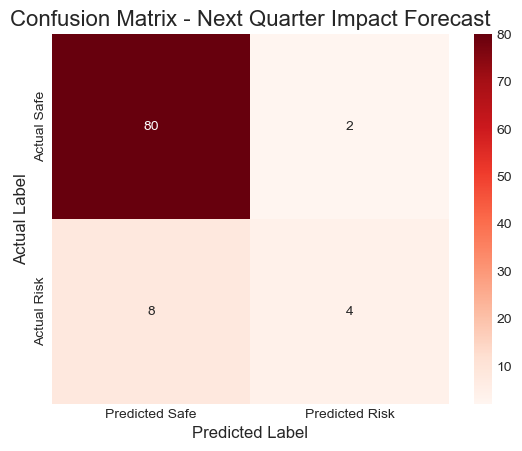

C:\Users\MUHAMMAD ZAIN\AppData\Local\Temp\ipykernel_8004\1743698066.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


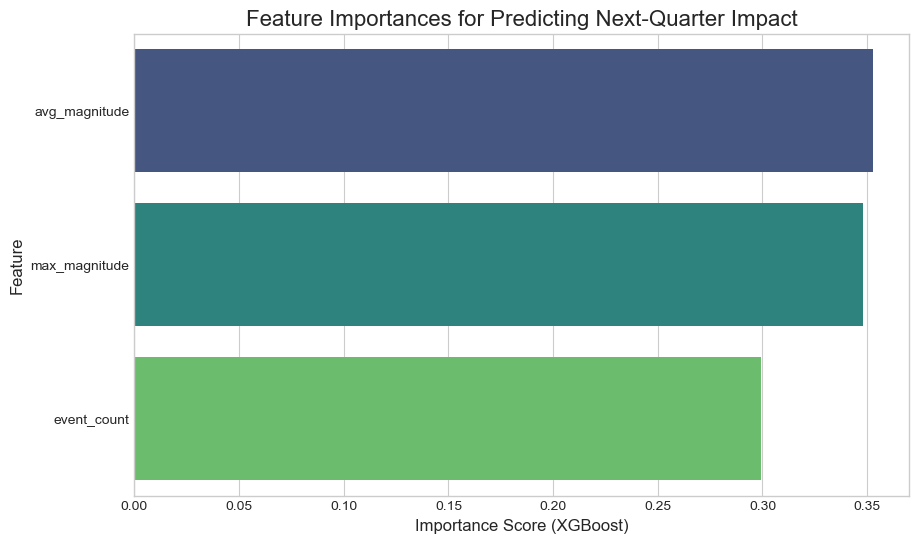

In [6]:
# --- Make Predictions on the Test Set ---
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# --- Evaluate Performance ---
print("--- Classification Report (Test Set) ---\n")
print(classification_report(y_test, y_pred, target_names=['No High-Impact Event Next Quarter', 'High-Impact Event Next Quarter']))

auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {auc_score:.4f}")

# --- Visualize Results ---
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Predicted Safe', 'Predicted Risk'],
            yticklabels=['Actual Safe', 'Actual Risk'])
plt.title('Confusion Matrix - Next Quarter Impact Forecast', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.savefig("../visuals/04_regional_impact_forecasting/After_Training/confusion_matrix.png")
plt.show()

# Feature Importance
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importances for Predicting Next-Quarter Impact', fontsize=16)
plt.xlabel('Importance Score (XGBoost)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.savefig("../visuals/04_regional_impact_forecasting/After_Training/feature_importance.png")
plt.show()

---

#### **Insights from Model Evaluation**

The evaluation of our regional forecasting model on the most recent, unseen data provides a clear and realistic picture of its capabilities. The results show that the model operates as a cautious but precise early-warning indicator.

#### **1. Performance as a "Conservative Alarm"**

The model's primary characteristic is its **high precision (67%)** but **low recall (33%)** for predicting high-impact quarters.

- **Interpretation:** This means the model is conservative. It correctly identifies only one-third of the upcoming risky periods, but when it does raise an alarm, it is correct two out of three times.
- **Practical Value:** For the Disaster Insight AI platform, this model is a valuable "Level 2" alert. An alert from this model signifies a high-confidence signal that warrants immediate, focused attention and resource allocation, even if it doesn't catch every single risky period.

The overall **ROC-AUC score of 0.6468** confirms that the model has learned a meaningful, predictive signal, performing significantly better than random chance, though there is clear potential for future improvement.

#### **2. What Drives the Prediction?**

The feature importance analysis reveals what the model has learned about the precursors to a high-impact event:

- **A Holistic View:** The model gives nearly equal weight to all three engineered features: `avg_magnitude`, `max_magnitude`, and `event_count`.
- **Key Insight:** This is a powerful finding. It indicates that no single indicator is enough to predict future risk. Instead, the model has learned that a combination of the frequency, average intensity, and peak intensity of the current quarter's seismic activity is the best predictor of a fatal event in the next quarter.

This evaluation demonstrates a successful proof-of-concept for a tactical, regional forecasting system. The model provides a reliable, albeit conservative, signal that can be a vital component of a proactive disaster response strategy.

---

## **6. Saving the Model**

In [7]:
# --- Save the Trained Model ---
output_dir = "../models/04_regional_impact_forecaster"
os.makedirs(output_dir, exist_ok=True)
model_path = os.path.join(output_dir, 'xgb_regional_impact_forecaster.joblib')

joblib.dump(model, model_path)
print(f"✅ Regional forecasting model saved successfully to: {model_path}")

✅ Regional forecasting model saved successfully to: ../models/04_regional_impact_forecaster\xgb_regional_impact_forecaster.joblib


## **7. Summary of Achievements**

In this notebook, we have successfully developed an advanced, tactical forecasting model. By engineering time-series features from raw earthquake data, we trained an **XGBoost** model to predict the probability of a high-impact (fatal) earthquake occurring in the next quarter for a specific set of high-risk countries.

While the model's recall is modest, it operates as a high-precision alarm, providing a reliable signal when it identifies a high-risk period (**67% precision**). The feature importance analysis revealed that a holistic view of the count, average magnitude, and max magnitude of the current quarter's seismic activity is the most effective predictor of future impact.

#### **Role in the "Disaster Insight AI" Project**

This model is a key "Level 2" analytical tool for our platform. While other models provide real-time detection and static risk, this one offers a proactive, tactical forecast. On the dashboard, it will power a feature that displays a ranked list of at-risk regions for the coming quarter, allowing NGOs and governments to strategically preposition resources and heighten monitoring.

---

#### **Limitations & Responsible Use**

While this model represents a significant step towards tactical forecasting, its responsible use requires a clear understanding of its specific limitations.

#### **Highly Specific Geographic Scope**

- **What it does:** This model is a specialist, not a generalist. It was exclusively trained on historical earthquake data from four specific countries: **China, India, Indonesia, and the Philippines**.
- **Reasoning:** These countries were chosen strategically based on the EDA in Notebook 02, which identified them as having a high frequency of recorded, high-impact seismic events in the **EMDAT** dataset. This focused approach allowed the model to learn from a denser, more regionally-specific dataset.
- **Crucial Implication:** The model's predictions are only valid for these four countries. It cannot and should not be used to forecast earthquake impact risk for any other country (e.g., Japan, Turkey, or the USA), as it has never seen their specific seismic patterns.

#### **Low Recall ("Missed Warnings")**

The model's primary weakness is its **low recall (33%)**, meaning it is designed to be conservative and will miss a significant portion of risky quarters. It should be treated as a high-confidence alert system, not a comprehensive safety net. A "Safe" prediction from this model does not guarantee safety.

#### **Probabilistic, Not Deterministic**

The model provides a probability of a high-impact quarter, not a certainty. An **80% probability** does not mean a fatal earthquake is guaranteed to happen; it means that in 10 quarters with similar preceding seismic activity, 8 of them experienced a fatal earthquake. It is a tool to manage risk and allocate attention, not a perfect crystal ball.

#### **Simplified Feature Set**

The predictions are based solely on a few lagging seismic indicators (**event_count**, **max_magnitude**, **avg_magnitude**). The model does not incorporate other potentially crucial data like fault line stress, recent volcanic activity, or granular geological surveys.